<h1> Detect Peaks and Split Video </h1>

For large video files, it's best to use OpenCV. This is the most straightforward and efficient approach but loses audio information while getting the job done. <br>
Alternatively, you could use `ffmpeg-python` to retain audio but this is troublesome for large videos as it reads the entire video into memory at once.

**To Try:** `PySceneDetect`'s video splitter

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from matplotlib.image import imread
from pathlib import Path
from utils import *

## Playground (Ignore)

In [2]:
data = pd.read_csv('tdk_bankrobbery/tdk-bankrobbery-stats.csv', skiprows=1)
scenes = pd.read_csv('tdk_bankrobbery/tdk-bankrobbery-Scenes.csv', skiprows=1)

In [3]:
data.head()
scenes.head()

,Frame Number,Timecode,content_val,delta_hue,delta_lum,delta_sat
0,1,00:00:00.042,7.875524,6.514187,7.492296,9.620090
1,2,00:00:00.083,6.751998,6.101535,5.829074,8.325385
2,3,00:00:00.125,8.437012,7.547390,7.758870,10.004774
3,4,00:00:00.167,8.767886,8.189345,7.991591,10.122721
4,5,00:00:00.209,7.997215,6.814317,7.709418,9.467909


,Scene Number,Start Frame,Start Timecode,Start Time (seconds),End Frame,End Timecode,End Time (seconds),Length (frames),Length (timecode),Length (seconds)
0,1,0,00:00:00.000,0.000,256,00:00:10.677,10.677,256,00:00:10.677,10.677
1,2,256,00:00:10.677,10.677,318,00:00:13.263,13.263,62,00:00:02.586,2.586
2,3,318,00:00:13.263,13.263,341,00:00:14.223,14.223,23,00:00:00.959,0.959
3,4,341,00:00:14.223,14.223,397,00:00:16.558,16.558,56,00:00:02.336,2.336
4,5,397,00:00:16.558,16.558,414,00:00:17.267,17.267,17,00:00:00.709,0.709


<Figure size 1440x720 with 0 Axes>

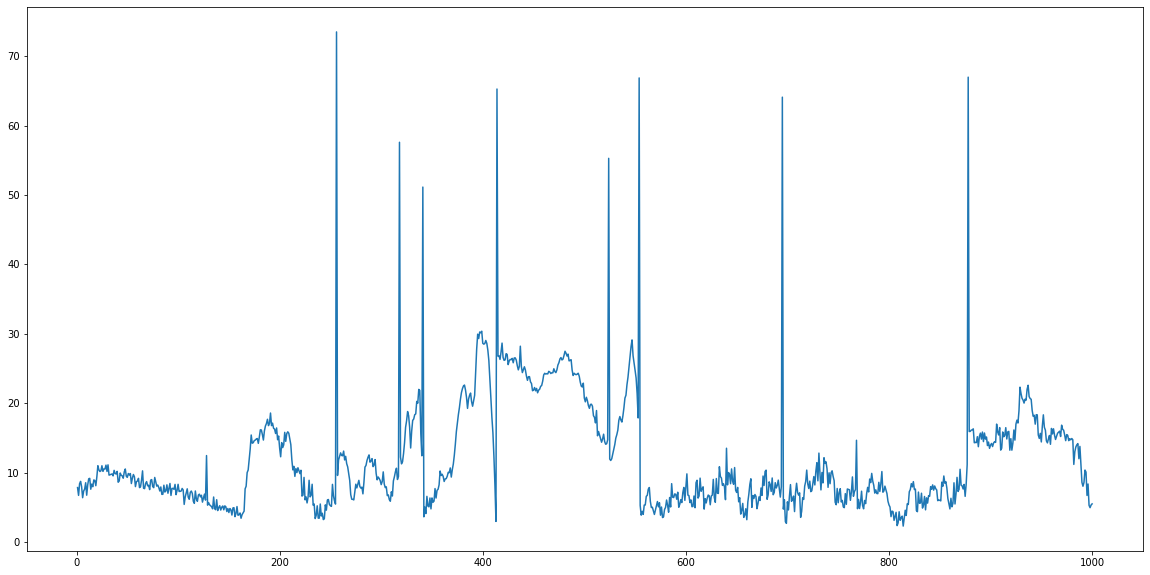

In [4]:
plt.figure(figsize=(20,10))
plt.plot('Frame Number', 'content_val', data=data[:1000])

In [2]:
#local imports
from tdk_bankrobbery.split_frames   import split_video
from tdk_bankrobbery.plot_help      import show_images

# flatten list of lists into single list
flatten = lambda x: list(itertools.chain.from_iterable(x))

def get_surrounding_frames(frames, pre = 5, post = 5):
    return flatten([np.arange(frame-pre, frame+post+1) for frame in frames])

def view_surrounding_frames(frame, pre = 5, post = 5):
    frame_ = get_surrounding_frames(frame, pre, post)
    images = [imread(f'{path_frames}/frame{i}.jpg') for i in frame_]
    titles = [f'Frame {i}' for i in frame_]
    show_images(images, 4, titles)
    
def view_plot(frame, pre = 5, post = 5):
    frame_ = get_surrounding_frames(frame, pre, post)
    subset = data[data['Frame Number'].isin(frame_)]
    plt.figure(figsize = (8, 4))
    plt.xlabel('Frame Number')
    plt.ylabel('Average HSL Value')
    plt.plot(subset['Frame Number'], subset['content_val'])
    
def inspect_frame(frame, pre = 5, post = 5):
    print(f'Frame #{frame}')
    view_plot(frame, pre, post)
    view_surrounding_frames(frame, pre, post)
    
path_frames = 'tdk_bankrobbery/frames/'

Frame #[397]


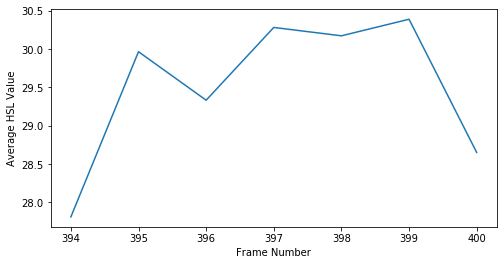

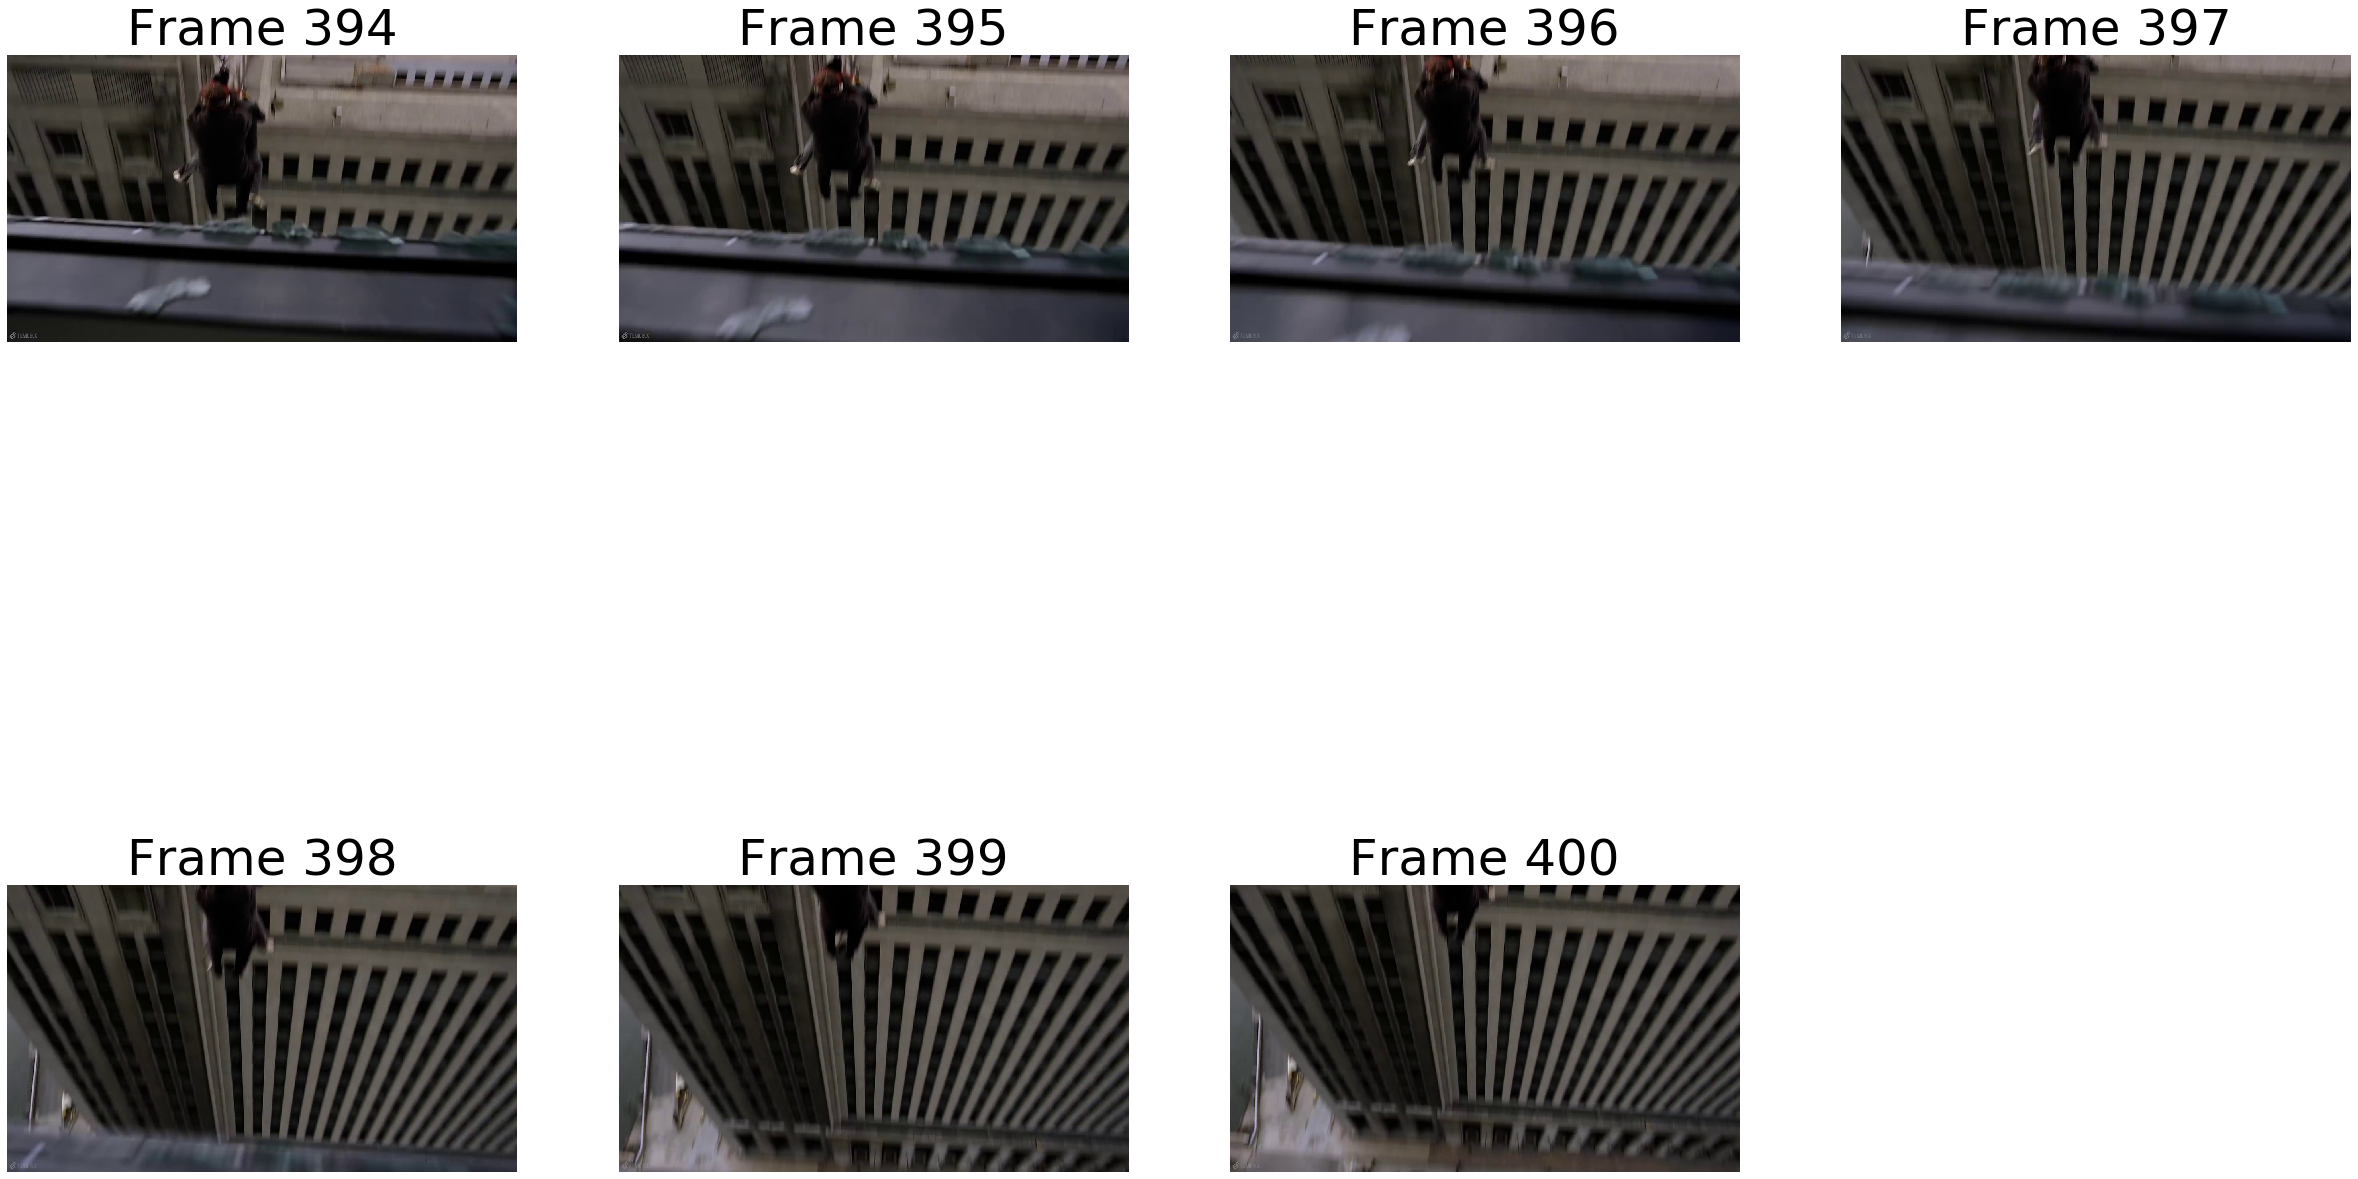

In [22]:
inspect_frame([397], 3, 3)

In [3]:
from tdk_bankrobbery.peak_detection import *

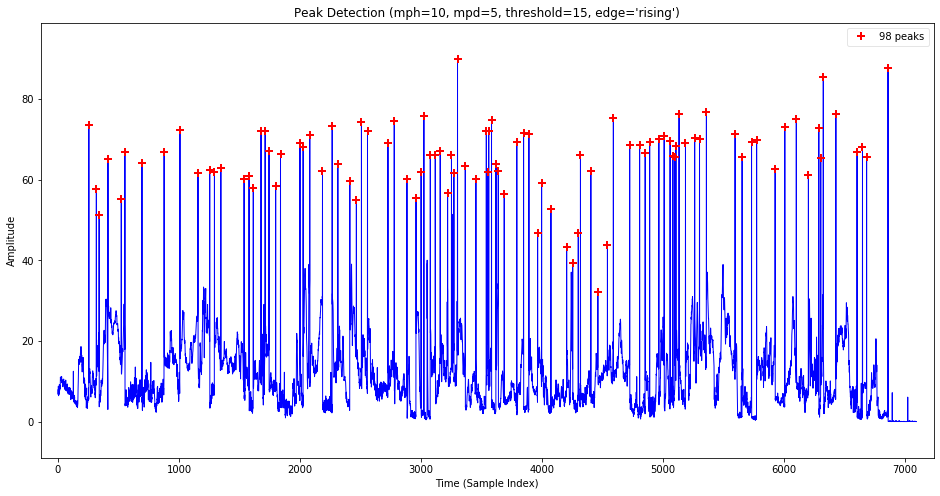

In [29]:
peaks = detect_peaks(data['content_val'], mph=10, mpd=5, show=True, threshold=15)

In [7]:
def split_video(input_video, timestamps, prefix='shot'):
    for i,peak in enumerate(timestamps):
        start = 0 if i is 0 else timestamps[i-1]
        print(start, timestamps[i]+1)
        video = (
            input_video
            .trim   (start = start, end = timestamps[i])
            .setpts ('PTS-STARTPTS')
        )

        audio = (
            input_video  #input_video['a']
            .filter_('atrim', start = start, end = timestamps[i])
            .filter_('asetpts', 'PTS-STARTPTS')
        )

        merged = ffmpeg.concat(video, audio, v=1, a=1)
        merged.output(f'{prefix}#{i+1}.mp4').run()

In [36]:
peaks

array([ 255,  317,  340,  413,  523,  553,  694,  877, 1008, 1157, 1254,
       1293, 1346, 1538, 1579, 1614, 1678, 1712, 1744, 1799, 1839, 2000,
       2026, 2081, 2186, 2266, 2313, 2412, 2466, 2508, 2558, 2727, 2779,
       2884, 2959, 3001, 3024, 3077, 3118, 3159, 3220, 3252, 3272, 3302,
       3366, 3454, 3540, 3551, 3560, 3583, 3620, 3639, 3688, 3792, 3848,
       3892, 3964, 3997, 4074, 4204, 4254, 4300, 4318, 4404, 4462, 4541,
       4590, 4725, 4807, 4853, 4890, 4966, 5010, 5059, 5082, 5099, 5107,
       5133, 5186, 5262, 5302, 5359, 5596, 5654, 5732, 5774, 5927, 6007,
       6102, 6202, 6288, 6304, 6325, 6429, 6604, 6649, 6683, 6860])

In [46]:
input_video = ffmpeg.input('tdk_bankrobbery/tdk-bankrobbery.mp4')

In [52]:
ffmpeg.probe('tdk_bankrobbery/tdk-bankrobbery.mp4')

{'streams': [{'index': 0,
   'codec_name': 'h264',
   'codec_long_name': 'H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10',
   'profile': 'Main',
   'codec_type': 'video',
   'codec_time_base': '8880121/425820000',
   'codec_tag_string': 'avc1',
   'codec_tag': '0x31637661',
   'width': 1280,
   'height': 720,
   'coded_width': 1280,
   'coded_height': 720,
   'has_b_frames': 1,
   'sample_aspect_ratio': '1:1',
   'display_aspect_ratio': '16:9',
   'pix_fmt': 'yuv420p',
   'level': 31,
   'color_range': 'tv',
   'color_space': 'bt709',
   'color_transfer': 'bt709',
   'color_primaries': 'bt709',
   'chroma_location': 'left',
   'refs': 1,
   'is_avc': 'true',
   'nal_length_size': '4',
   'r_frame_rate': '24000/1001',
   'avg_frame_rate': '212910000/8880121',
   'time_base': '1/90000',
   'start_pts': 0,
   'start_time': '0.000000',
   'duration_ts': 26640363,
   'duration': '296.004033',
   'bit_rate': '1184985',
   'bits_per_raw_sample': '8',
   'nb_frames': '7097',
   'disposition': {'def

In [53]:
split_video(input_video, peaks / (24000/1001), prefix='splits/shot')

0 11.635625
10.635625 14.221541666666665
13.221541666666665 15.180833333333332
14.180833333333332 18.225541666666665
17.225541666666665 22.813458333333333
21.813458333333333 24.064708333333332
23.064708333333332 29.94558333333333
28.94558333333333 37.57820833333333
36.57820833333333 43.041999999999994
42.041999999999994 49.256541666666664
48.256541666666664 53.302249999999994
52.302249999999994 54.928875
53.928875 57.13941666666666
56.13941666666666 65.14741666666666
64.14741666666666 66.85745833333333
65.85745833333333 68.31725
67.31725 70.98658333333333
69.98658333333333 72.40466666666666
71.40466666666666 73.73933333333333
72.73933333333333 76.03329166666666
75.03329166666666 77.70162499999999
76.70162499999999 84.41666666666666
83.41666666666666 85.50108333333333
84.50108333333333 87.79504166666666
86.79504166666666 92.17441666666666
91.17441666666666 95.51108333333333
94.51108333333333 97.471375
96.471375 101.6005
100.6005 103.85274999999999
102.85274999999999 105.60449999999999
1

KeyboardInterrupt: 

In [51]:
start, end = 0, 10

video = (
    input_video
    .trim   (start = start, end = end)
    .setpts ('PTS-STARTPTS')
)

audio = (
    input_video  #input_video['a']
    .filter_('atrim', start = start, end = end)
    .filter_('asetpts', 'PTS-STARTPTS')
)

merged = ffmpeg.concat(video, audio, v=1, a=1)
merged.output(f'splits/shot#tmp.mp4').run()

(None, None)

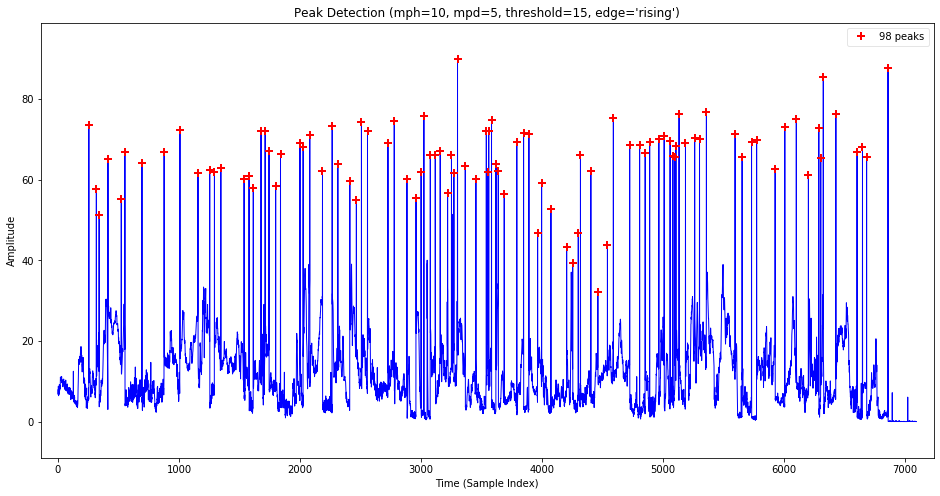

array([ 255,  317,  340,  413,  523,  553,  694,  877, 1008, 1157, 1254,
       1293, 1346, 1538, 1579, 1614, 1678, 1712, 1744, 1799, 1839, 2000,
       2026, 2081, 2186, 2266, 2313, 2412, 2466, 2508, 2558, 2727, 2779,
       2884, 2959, 3001, 3024, 3077, 3118, 3159, 3220, 3252, 3272, 3302,
       3366, 3454, 3540, 3551, 3560, 3583, 3620, 3639, 3688, 3792, 3848,
       3892, 3964, 3997, 4074, 4204, 4254, 4300, 4318, 4404, 4462, 4541,
       4590, 4725, 4807, 4853, 4890, 4966, 5010, 5059, 5082, 5099, 5107,
       5133, 5186, 5262, 5302, 5359, 5596, 5654, 5732, 5774, 5927, 6007,
       6102, 6202, 6288, 6304, 6325, 6429, 6604, 6649, 6683, 6860])

In [57]:
detect_peaks(data['content_val'], mph=10, mpd=5, show=True, threshold=15)

In [58]:
os.chdir('/Users/rahulsomani/Desktop/test-videos/')

In [60]:
!scenedetect -i interstellar-waves.mp4 -s interstellar-waves-stats.csv detect-content

[PySceneDetect] Loaded 1 video, framerate: 23.98 FPS, resolution: 1280 x 720
[PySceneDetect] Downscale factor set to 5, effective resolution: 256 x 144
[PySceneDetect] Detecting scenes...
100%|██████████████████████████████████| 5627/5627 [00:22<00:00, 252.67frames/s]
[PySceneDetect] Processed 5627 frames in 22.3 seconds (average 252.52 FPS).
[PySceneDetect] Saving frame metrics to stats file: interstellar-waves-stats.csv
Writing 5626 frames to CSV...
[PySceneDetect] Detected 88 scenes, average shot length 2.7 seconds.
[PySceneDetect] Comma-separated timecode list:
  00:00:00.918,00:00:02.461,00:00:03.629,00:00:04.796,00:00:06.673,00:00:08.217,00:00:13.347,00:00:22.564,00:00:28.528,00:00:30.906,00:00:43.252,00:00:49.508,00:00:55.180,00:00:57.849,00:00:59.768,00:01:02.729,00:01:04.606,00:01:10.445,00:01:12.614,00:01:14.950,00:01:17.703,00:01:29.381,00:01:31.174,00:01:33.719,00:01:37.597,00:01:40.309,00:01:41.893,00:01:44.896,00:01:47.858,00:01:50.068,00:01:52.362,00:01:57.367,00:02:00.5

In [62]:
data = pd.read_csv('interstellar-waves-stats.csv', skiprows=1)

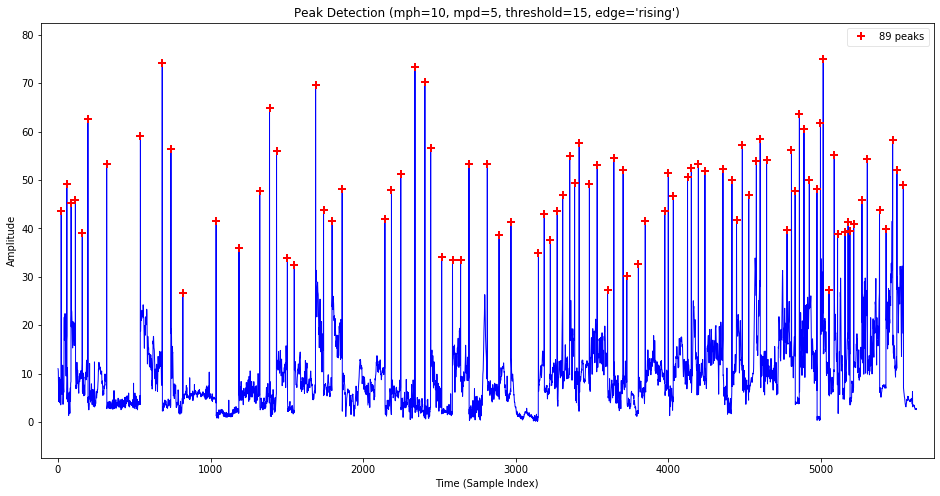

In [71]:
peaks = detect_peaks(data['content_val'], mph=10, mpd=5, show=True, threshold=15)

In [67]:
ffmpeg.probe('interstellar-waves.mp4')

{'streams': [{'index': 0,
   'codec_name': 'h264',
   'codec_long_name': 'H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10',
   'profile': 'Main',
   'codec_type': 'video',
   'codec_time_base': '21122351/1012860000',
   'codec_tag_string': 'avc1',
   'codec_tag': '0x31637661',
   'width': 1280,
   'height': 720,
   'coded_width': 1280,
   'coded_height': 720,
   'has_b_frames': 1,
   'sample_aspect_ratio': '1:1',
   'display_aspect_ratio': '16:9',
   'pix_fmt': 'yuv420p',
   'level': 31,
   'color_range': 'tv',
   'color_space': 'bt709',
   'color_transfer': 'bt709',
   'color_primaries': 'bt709',
   'chroma_location': 'left',
   'refs': 1,
   'is_avc': 'true',
   'nal_length_size': '4',
   'r_frame_rate': '24000/1001',
   'avg_frame_rate': '506430000/21122351',
   'time_base': '1/90000',
   'start_pts': 0,
   'start_time': '0.000000',
   'duration_ts': 21122351,
   'duration': '234.692789',
   'bit_rate': '1284093',
   'bits_per_raw_sample': '8',
   'nb_frames': '5627',
   'disposition': {'

In [68]:
fps = 24000/1001

In [69]:
os.mkdir('interstellar-splits')

In [72]:
split_video(ffmpeg.input('interstellar-waves.mp4'), peaks / fps, 'interstellar-splits/shot')

0 1.875875
0.875875 3.419083333333333
2.419083333333333 4.586916666666666
3.5869166666666663 5.75475
4.75475 7.631625
6.631625 9.174833333333332
8.174833333333332 14.304958333333332
13.304958333333332 23.522499999999997
22.522499999999997 29.486791666666665
28.486791666666665 31.864166666666666
30.864166666666666 35.117416666666664
34.117416666666664 44.20983333333333
43.20983333333333 50.46608333333333
49.46608333333333 56.138416666666664
55.138416666666664 58.80775
57.80775 60.72633333333333
59.72633333333333 63.687625
62.687625 65.5645
64.5645 71.40366666666667
70.40366666666667 73.57249999999999
72.57249999999999 75.90816666666666
74.90816666666666 78.66091666666667
77.66091666666667 90.33924999999999
89.33924999999999 92.13270833333333
91.13270833333333 94.67691666666666
93.67691666666666 98.55579166666666
97.55579166666666 101.26683333333332
100.26683333333332 102.85175
101.85175 105.85475
104.85475 108.81604166666666
107.81604166666666 111.02658333333332
110.02658333333332 113.3

## Split Using OpenCV

This allows you to decode a video frame-by-frame, thus allowing you to read in massive video files. <br>
The only drawback is that you lose audio output. <br>
The video splitting also seems to be faster, and less of a load on the CPU.

<h3> OpenCV Properties with Indices

```
0. CV_CAP_PROP_POS_MSEC Current position of the video file in milliseconds.
1. CV_CAP_PROP_POS_FRAMES 0-based index of the frame to be decoded/captured next.
2. CV_CAP_PROP_POS_AVI_RATIO Relative position of the video file
3. CV_CAP_PROP_FRAME_WIDTH Width of the frames in the video stream.
4. CV_CAP_PROP_FRAME_HEIGHT Height of the frames in the video stream.
5. CV_CAP_PROP_FPS Frame rate.
6. CV_CAP_PROP_FOURCC 4-character code of codec.
7. CV_CAP_PROP_FRAME_COUNT Number of frames in the video file.
8. CV_CAP_PROP_FORMAT Format of the Mat objects returned by retrieve() .
9. CV_CAP_PROP_MODE Backend-specific value indicating the current capture mode.
10. CV_CAP_PROP_BRIGHTNESS Brightness of the image (only for cameras).
11. CV_CAP_PROP_CONTRAST Contrast of the image (only for cameras).
12. CV_CAP_PROP_SATURATION Saturation of the image (only for cameras).
13. CV_CAP_PROP_HUE Hue of the image (only for cameras).
14. CV_CAP_PROP_GAIN Gain of the image (only for cameras).
15. CV_CAP_PROP_EXPOSURE Exposure (only for cameras).
16. CV_CAP_PROP_CONVERT_RGB Boolean flags indicating whether images should be converted to RGB.
17. CV_CAP_PROP_WHITE_BALANCE Currently unsupported
18. CV_CAP_PROP_RECTIFICATION Rectification flag for stereo cameras (note: only supported by DC1394 v 2.x backend currently)
```

In [4]:
import cv2
from tdk_bankrobbery.peak_detection import *

In [32]:
video_path = '/Users/rahulsomani/Desktop/test-videos/interstellar-waves.mp4'
stats_file = video_path.rsplit('/')[-1].split('.')[0] + '-stats.csv'
stats_file

'interstellar-waves-stats.csv'

In [65]:
video_path = Path('/Users/rahulsomani/Desktop/test-videos/')
video_file = str(video_path/'interstellar-waves.mp4')
stats_file = str(video_file).split('.')[0] + '-stats.csv'
splits_dir = str(video_path/(video_file.split('.')[0] + '-splits')) + '/'

os.mkdir(splits_dir) if not os.path.exists(splits_dir) else None

In [48]:
!scenedetect -i {video_file} -s {stats_file} detect-content

[PySceneDetect] Loaded 1 video, framerate: 23.98 FPS, resolution: 1280 x 720
[PySceneDetect] Downscale factor set to 5, effective resolution: 256 x 144
[PySceneDetect] Detecting scenes...
100%|██████████████████████████████████| 5627/5627 [00:20<00:00, 274.48frames/s]
[PySceneDetect] Processed 5627 frames in 20.5 seconds (average 274.36 FPS).
[PySceneDetect] Saving frame metrics to stats file: interstellar-waves-stats.csv
Writing 5626 frames to CSV...
[PySceneDetect] Detected 88 scenes, average shot length 2.7 seconds.
[PySceneDetect] Comma-separated timecode list:
  00:00:00.918,00:00:02.461,00:00:03.629,00:00:04.796,00:00:06.673,00:00:08.217,00:00:13.347,00:00:22.564,00:00:28.528,00:00:30.906,00:00:43.252,00:00:49.508,00:00:55.180,00:00:57.849,00:00:59.768,00:01:02.729,00:01:04.606,00:01:10.445,00:01:12.614,00:01:14.950,00:01:17.703,00:01:29.381,00:01:31.174,00:01:33.719,00:01:37.597,00:01:40.309,00:01:41.893,00:01:44.896,00:01:47.858,00:01:50.068,00:01:52.362,00:01:57.367,00:02:00.5

In [60]:
data = pd.read_csv(stats_file, skiprows=1)
peaks = detect_peaks(data['content_val'], mph=10, mpd=5, show=False, threshold=15)
peaks

array([  21,   58,   86,  114,  159,  196,  319,  540,  683,  740,  818,
       1036, 1186, 1322, 1386, 1432, 1503, 1548, 1688, 1740, 1796, 1862,
       2142, 2185, 2246, 2339, 2404, 2442, 2514, 2585, 2638, 2693, 2813,
       2890, 2968, 3148, 3186, 3226, 3271, 3307, 3353, 3385, 3415, 3482,
       3533, 3601, 3642, 3703, 3727, 3803, 3848, 3976, 3999, 4032, 4125,
       4150, 4196, 4239, 4357, 4416, 4446, 4484, 4526, 4576, 4601, 4643,
       4777, 4806, 4830, 4858, 4888, 4923, 4973, 4996, 5014, 5052, 5086,
       5108, 5157, 5177, 5189, 5214, 5268, 5303, 5383, 5426, 5469, 5497,
       5539])

In [63]:
cap = cv2.VideoCapture(video_file)

cap.get(cv2.CAP_PROP_FPS)
cap.get(cv2.CAP_PROP_FRAME_COUNT)
int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

23.976024259799487

5627.0

720

In [72]:
cap = cv2.VideoCapture(video_file)
h,w = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = cap.get(cv2.CAP_PROP_FPS)

for i,peak in enumerate(peaks[:2]):
    print(peak)
    out = cv2.VideoWriter(f'{splits_dir}shot#{i+1}.mp4',
                          #cv2.VideoWriter_fourcc('M','J','P','G'),
                          cv2.VideoWriter_fourcc(*'MP4V'),
                          cap.get(cv2.CAP_PROP_FPS),
                          (w,h))
    while True:
        ret, frame = cap.read()
        if ret == True: 
            out.write(frame)
            if cap.get(cv2.CAP_PROP_POS_FRAMES) == peak: break
        else: break
            
    out.release()
cap.release()
            
    

21
58


### Splitting using `PySceneDetect`

In [114]:
from scenedetect.frame_timecode import FrameTimecode
from scenedetect.video_splitter import split_video_ffmpeg, split_video_mkvmerge

In [111]:
fps

23.976024259799487

In [100]:
frame_timecodes = [FrameTimecode(int(x), fps) for x in peaks]
frame_timecodes[:3]

[FrameTimecode(frame=21, fps=23.976024),
 FrameTimecode(frame=58, fps=23.976024),
 FrameTimecode(frame=86, fps=23.976024)]

In [101]:
video_file

'/Users/rahulsomani/Desktop/test-videos/interstellar-waves.mp4'

In [110]:
split_video_ffmpeg??

In [112]:
split_video_ffmpeg([video_file], frame_timecodes)


TypeError: split_video_ffmpeg() missing 2 required positional arguments: 'output_file_template' and 'video_name'

In [119]:
split_video_ffmpeg([video_file], [frame_timecodes[0], frame_timecodes[1] ], output_file_template='zz/', video_name='new.mp4')


TypeError: 'FrameTimecode' object is not subscriptable

In [118]:
[frame_timecodes[0], frame_timecodes[1] ]

[FrameTimecode(frame=21, fps=23.976024),
 FrameTimecode(frame=58, fps=23.976024)]

In [115]:
split_video_mkvmerge([video_file], [frame_timecodes[0], frame_timecodes[1] ], )